# Logistic Regression

In [6]:
%matplotlib inline

## Iris Dataset

In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

- LogisticRegressionはlogitsを返してsoftmaxを通さないので注意
- loss関数のほうにsoftmaxが入る
- なので見た目はLinearRegressionとまったく同じ

- 入力は `FloatTensor` ラベルは `LongTensor` である必要がある 
- TODO: DataSetとDataLoaderを使って書き直す
- Validで精度を求める

In [9]:
# hyperparameters
input_size = 4
num_classes = 3
num_epochs = 10000
learning_rate = 0.01

iris = load_iris()
X = iris.data
y = iris.target
# print(X.shape)
# print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

# データの標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# print(np.mean(X_train, axis=0))
# print(np.std(X_train, axis=0))

class LogisticRegression(nn.Module):

    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

model = LogisticRegression(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train(X_train, y_train):
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).long()
    
    optimizer.zero_grad()
    outputs = model(inputs)
    
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    return loss.item()

def valid(X_test, y_test):
    inputs = torch.from_numpy(X_test).float()
    targets = torch.from_numpy(y_test).long()

    outputs = model(inputs)
    val_loss = criterion(outputs, targets)
    
    # 精度を求める
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum()
    val_acc = correct.float() / targets.size(0)

    return val_loss.item(), val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    perm = np.arange(X_train.shape[0])
    np.random.shuffle(perm)
    X_train = X_train[perm]
    y_train = y_train[perm]
    
    loss = train(X_train, y_train)
    val_loss, val_acc = valid(X_test, y_test)
    
    if epoch % 1000 == 0:
        print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
              % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 1.4469 val_loss: 1.3937 val_acc: 0.0400
epoch 1000, loss: 0.3398 val_loss: 0.3512 val_acc: 0.9000
epoch 2000, loss: 0.2641 val_loss: 0.2812 val_acc: 0.9000
epoch 3000, loss: 0.2202 val_loss: 0.2422 val_acc: 0.9400
epoch 4000, loss: 0.1907 val_loss: 0.2160 val_acc: 0.9400
epoch 5000, loss: 0.1695 val_loss: 0.1969 val_acc: 0.9400
epoch 6000, loss: 0.1535 val_loss: 0.1825 val_acc: 0.9600
epoch 7000, loss: 0.1410 val_loss: 0.1711 val_acc: 0.9600
epoch 8000, loss: 0.1310 val_loss: 0.1620 val_acc: 0.9600
epoch 9000, loss: 0.1228 val_loss: 0.1545 val_acc: 0.9600


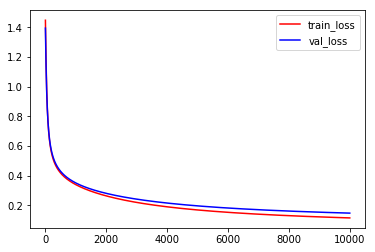

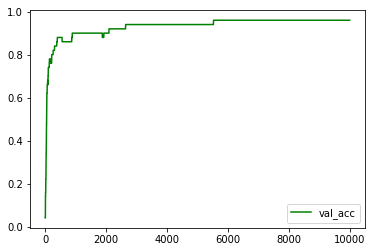

In [10]:
# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()

## MNIST

- MNISTはPyTorchの標準機能でデータセットをダウンロードできる
- バッチ単位で読み込めるDataLoaderも簡単に使える

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
# Hyper Parameters 
input_size = 784
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.001

# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [3]:
print(len(train_dataset))
print(len(test_dataset))

# 1データだけ取得
image, label = iter(train_loader).next()
print(type(image), type(label))
print(image.size(), label.size())

60000
10000
<class 'torch.FloatTensor'> <class 'torch.LongTensor'>
torch.Size([100, 1, 28, 28]) torch.Size([100])


In [7]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

model = LogisticRegression(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


def train(train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    
    return train_loss.data[0]


def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
        total += labels.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    
    return val_loss.data[0], val_acc


loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 2.0284 val_loss: 1.7815 val_acc: 0.7163
epoch 1, loss: 1.6136 val_loss: 1.4462 val_acc: 0.7813
epoch 2, loss: 1.3475 val_loss: 1.2290 val_acc: 0.8052
epoch 3, loss: 1.1713 val_loss: 1.0817 val_acc: 0.8181
epoch 4, loss: 1.0486 val_loss: 0.9767 val_acc: 0.8268
epoch 5, loss: 0.9590 val_loss: 0.8984 val_acc: 0.8359
epoch 6, loss: 0.8908 val_loss: 0.8378 val_acc: 0.8421
epoch 7, loss: 0.8372 val_loss: 0.7895 val_acc: 0.8470
epoch 8, loss: 0.7938 val_loss: 0.7500 val_acc: 0.8508
epoch 9, loss: 0.7579 val_loss: 0.7172 val_acc: 0.8552
epoch 10, loss: 0.7277 val_loss: 0.6893 val_acc: 0.8594
epoch 11, loss: 0.7019 val_loss: 0.6653 val_acc: 0.8623
epoch 12, loss: 0.6795 val_loss: 0.6444 val_acc: 0.8640
epoch 13, loss: 0.6599 val_loss: 0.6260 val_acc: 0.8663
epoch 14, loss: 0.6426 val_loss: 0.6098 val_acc: 0.8680
epoch 15, loss: 0.6271 val_loss: 0.5952 val_acc: 0.8711
epoch 16, loss: 0.6132 val_loss: 0.5821 val_acc: 0.8720
epoch 17, loss: 0.6007 val_loss: 0.5701 val_acc: 0.8732
ep

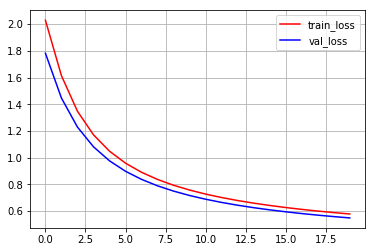

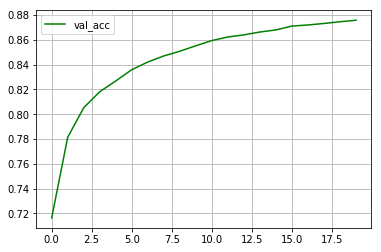

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.grid()